<a href="https://colab.research.google.com/github/juDEcorous/ML-Clustering/blob/main/Core_Analysis_of_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis of KMeans (Core) </br>
Jude Maico Jr


1. Create analytical visualizations that explore statistics for each feature for each cluster.
2. Write a description of each cluster, based on the visualizations you created. Do more than describe the numbers, try to see past the numbers and describe what kinds of people are represented by each cluster. Include at least one insight for each cluster.
3. Create one or two recommendations for your stakeholders (the credit card company) regarding how they should market credit cards differently, or which cards they should market, to each cluster based on your data and insights.



# Imports

In [ ]:
# Normal Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing Imports
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# ML
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
path = '/content/drive/MyDrive/clustering data/cust_seg.csv'
df = pd.read_csv(path, index_col = 'Customer Id')

# Data Inspection

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 1 to 850
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 66.4 KB


,Unnamed: 0,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Customer Id,,,,,,,,,
1,0,41,2,6,19,0.124,1.073,0.0,6.3
2,1,47,1,26,100,4.582,8.218,0.0,12.8
3,2,33,2,10,57,6.111,5.802,1.0,20.9
4,3,29,2,4,19,0.681,0.516,0.0,6.3
5,4,47,1,31,253,9.308,8.908,0.0,7.2


- Needs to drop unwanted column (Unnamed: 0)
- All columns are numerical, no need for OHE
- Card Debt and Other Debt needs to be understood more
- Missing values seen on Defaulted column: We cannot drop the rows as there are 19.36% difference. Since it is categorical we will put frequently use to fill the missing values.

In [ ]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
# double checking the dataframe
df.sample(3)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Customer Id,,,,,,,,
733,23,2,2,48,0.511,3.089,NaN,7.5
532,31,1,12,31,2.057,5.290,0.0,23.7
398,45,2,21,132,2.558,1.402,0.0,3.0


# Data Preprocessing

In [ ]:
# filling missing values on defaulted column with most frequent
scaler = StandardScaler()
freq_imputer = SimpleImputer(strategy = 'most_frequent')

defaulted_pipeline = make_pipeline(freq_imputer, scaler)
defaulted_tuple = (defaulted_pipeline, ['Defaulted'])

In [ ]:
# scaling other columns 
columns_df =  df.drop(columns = 'Defaulted')
columns = list(columns_df.columns)

columns_scaler = StandardScaler()

columns_tuple = (columns_scaler, columns)

In [ ]:
# preprocessor
preprocessor = make_column_transformer(defaulted_tuple, columns_tuple, remainder = 'drop')

# Fit and Transform

In [ ]:
preprocess_df = preprocessor.fit_transform(df)
preprocess_df

array([[-0.52379654,  0.74291541,  0.31212243, ..., -0.68381116,
        -0.59048916, -0.57652509],
       [-0.52379654,  1.48949049, -0.76634938, ...,  1.41447366,
         1.51296181,  0.39138677],
       [ 1.90913822, -0.25251804,  0.31212243, ...,  2.13414111,
         0.80170393,  1.59755385],
       ...,
       [ 1.90913822, -1.24795149,  2.46906604, ...,  0.5766659 ,
         0.03863257,  3.45892281],
       [-0.52379654, -0.37694723, -0.76634938, ..., -0.68757659,
        -0.70147601, -1.08281745],
       [-0.52379654,  2.1116364 , -0.76634938, ...,  0.13611081,
         0.16463355, -0.2340332 ]])

## Inertia

Text(0, 0.5, 'inertia')

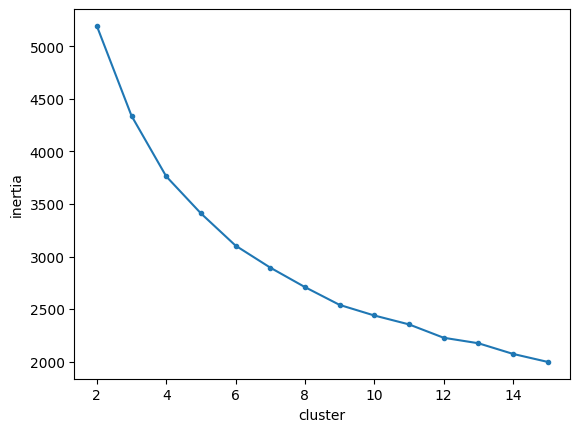

In [ ]:
# empty list of inertias
inertia = []

# loop through k-values and store inertias on the list.
for i in range(2, 16):
  kmeans = KMeans(n_clusters = i, n_init = 10, random_state = 42) 
  # FutureWarning: The default value of `n_init` will change from 10 to 'auto'
  kmeans.fit(preprocess_df)
  inertia.append(kmeans.inertia_)

# visualise
plt.plot(range(2, 16), inertia, marker = '.')
plt.xlabel('cluster')
plt.ylabel('inertia')

Our graph doesn't show any distinct elbow. Seems like 5, 6 and 7 shows a good number of cluster. But with 850 samples those numbers seems high, we are going to use Silhoette Score.

## Silhouette Score

,clusters,silhouette_score
0,2,0.340117
1,3,0.287387
2,4,0.253074
3,5,0.249648
4,6,0.243115
5,7,0.218830
11,13,0.207369
9,11,0.206149
10,12,0.205324
6,8,0.204773


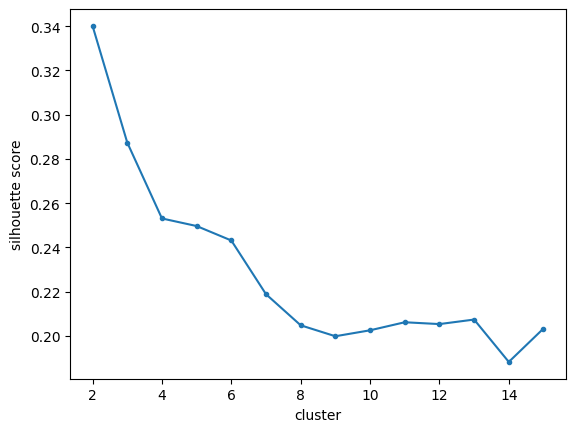

In [ ]:
# list for silhoette Score
silhouette_scores = []

for k in range(2, 16):
  kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 42)
  kmeans.fit(preprocess_df)
  silhouette_scores.append(silhouette_score(preprocess_df, kmeans.labels_))

# visualize silhouette_scores
plt.plot(range(2, 16), silhouette_scores,  marker = '.')
plt.xlabel('cluster')
plt.ylabel('silhouette score')

# df for the score
silhouette_df = pd.DataFrame()
silhouette_df['clusters'] = range(2, 16)
silhouette_df['silhouette_score'] = silhouette_scores
silhouette_df.sort_values(by = 'silhouette_score', ascending = False)

## K Base
The graph in our Siloutte graph clearly shows that we should be using cluster 2. Since we only have 850 samples I will be using a 2 as my cluster.

In [ ]:
# implementing 2 cluster model
cluster_2 = KMeans(n_clusters = 2, n_init = 10, random_state = 42)
cluster_2.fit(preprocess_df)

# add cluster in df
df['Cluster'] = cluster_2.labels_

df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Cluster
Customer Id,,,,,,,,,
1,41,2,6,19,0.124,1.073,0.0,6.3,0
2,47,1,26,100,4.582,8.218,0.0,12.8,1
3,33,2,10,57,6.111,5.802,1.0,20.9,1
4,29,2,4,19,0.681,0.516,0.0,6.3,0
5,47,1,31,253,9.308,8.908,0.0,7.2,1


# Analization and Visualization of the Clusters


In [ ]:
# group cluster and aggregate values by mean
# as_index = False, for cluster to be a column
cluster_groups = df.groupby('Cluster', as_index = False).mean()
cluster_groups

,Cluster,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,32.968563,1.645210,6.492515,33.618263,0.937349,1.899054,0.259928,9.126796
1,1,42.593407,1.950549,16.175824,94.598901,3.923890,7.408731,0.267123,14.006593


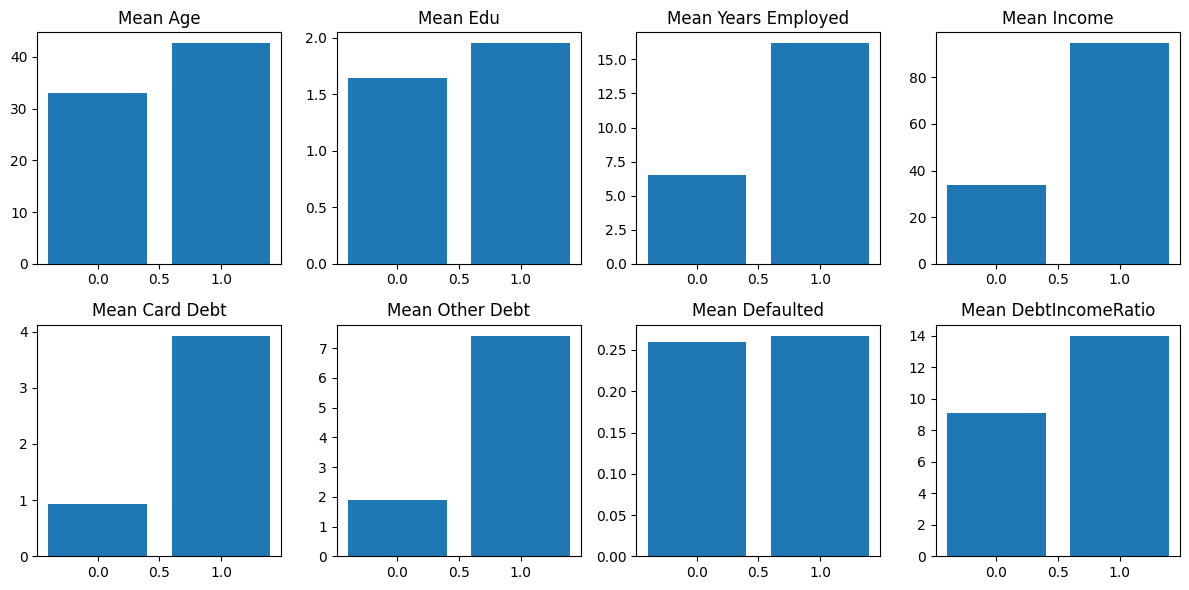

In [ ]:
# visualization
fig, axes = plt.subplots(2, 4, figsize = (12, 6))

axes = axes.ravel()

# loop for columns excluding the Cluster column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['Cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

plt.tight_layout()

## Description of each cluster

 1. **Cluster 0:**
- Cluster 0 are the people who are younger than 33 years old. These people spend lesser time with education, they have less work experience, lower income, and lower debt. This cluster have almost the same ratio with regards to Defaulted.

 2. **Cluster 1:**
- Cluster 1 are those people who are above 33 years old. These people have higher job experiences, makes higher salary. With this regards they also have remarkably higher debt. 

## Two recommendations for stakeholders

* **Recommendation 1:**
 - For the Cluster 0 costumers, we should offer $0 annual fee as these are the people who have lower income and probably wants to save as much. 

* **Recommendation 2:**
 - Cluster 1 makes higher pay, we can offer the Premium and Luxury Credit Cards. The Annual fee will be compensated with credit card bonus and higher credit limit which I believe works best for them.

